# HOG Descriptors και μηχανική μάθηση

### Εφαρμογή: Ανίχνευση προσώπου σε εικόνες

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## HOG Features

Θα χρησιμοποιήσουμε την έτοιμη συνάρτηση για εξαγωγή HOG χαρακτηριστικών από εικόνες:

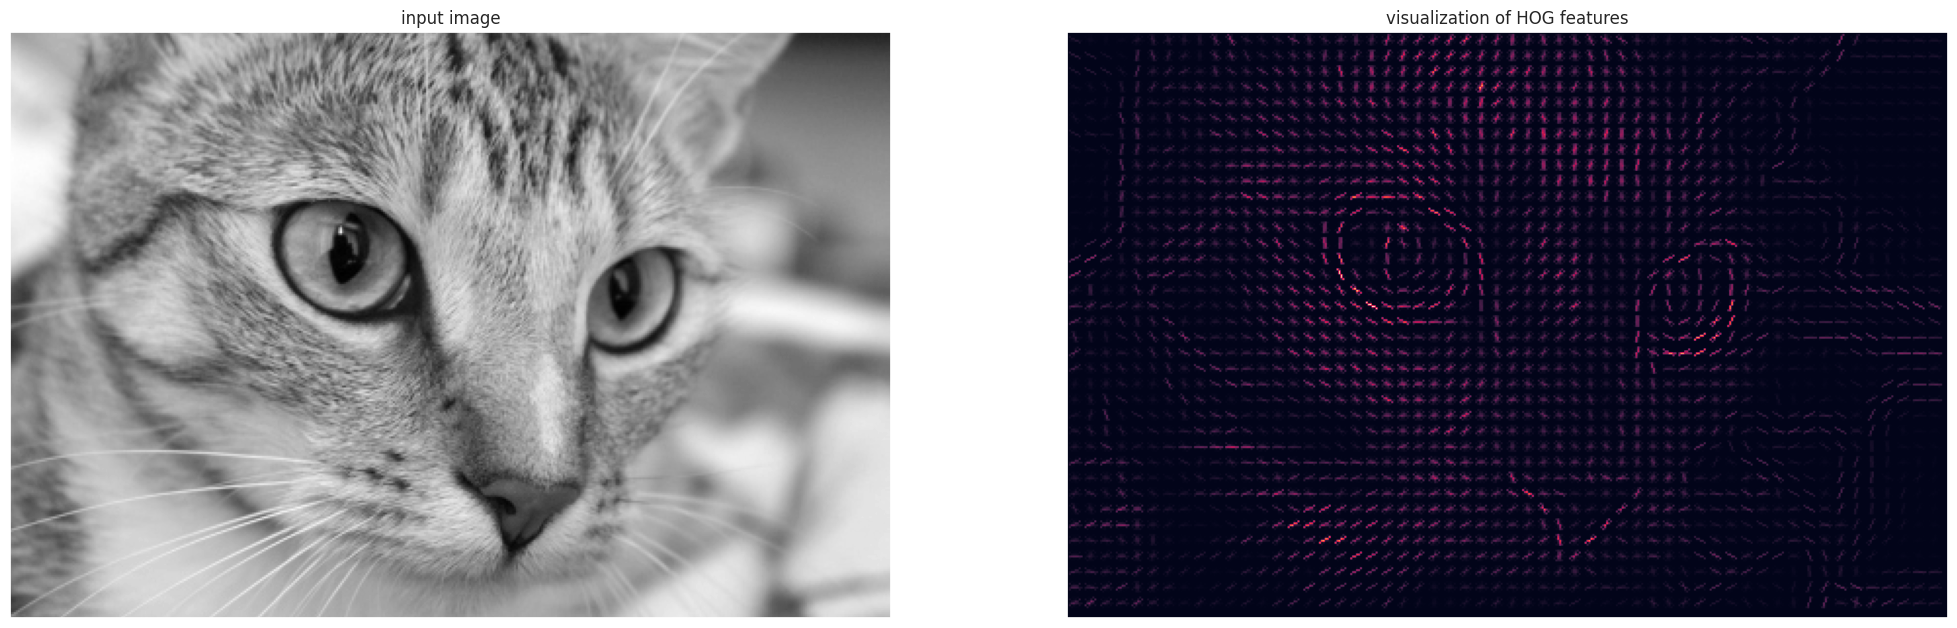

In [10]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(25, 16),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

# Απλός ανιχνευτής προσώπου με HOG descriptors

Από τη βιβλιοθήκη Scikit-Learn θα χρησιμοποιήσουμε ένα γραμμικό SVM για τους περιγραφείς HOG των εικόνων με σκοπό τη δημιουργία ενός απλού ανιχνευτή προσώπου ως εξής: 

1. Ορίστε ένα σύνολο εικόνων προσώπου το οποίο θα αποτελέσει τα "θετικά" δείγματα εκπαίδευσης. 
2. Ορίστε ένα σύνολο εικόνων που δεν περιέχουν προσώπα το οποίο θα αποτελέσει τα "αρνητικά" δείγματα εκπαίδευσης.
3. Εξαγάγετε τα χαρακτηριστικά HOG από τα δείγματα εκπαίδευσης.
4. Εκπαιδεύστε ένα γραμμικό ταξινομητή SVM σε αυτά τα δείγματα. 
5. Για μια "άγνωστη" εικόνα όπου θέλετε να δείτε αν περιέχει πρόσωπο, "περάστε" ένα συρόμενο παράθυρο κατά μήκος της εικόνας και χρησιμοποιώντας το μοντέλο αξιολογήστε εάν αυτό το παράθυρο περιέχει πρόσωπο ή όχι.
6. Εάν οι ανιχνεύσεις επικαλύπτονται, συνδυάστε τις σε ένα μόνο παράθυρο. 



#### 1. Ορίστε ένα σύνολο εικόνων προσώπου το οποίο θα αποτελέσει τα "θετικά" δείγματα εκπαίδευσης.
θα χρησιμοποιήσουμε το σύνολο δεδομένων Labeled Faces in the Wild, το οποίο διατίθεται από το Scikit-Learn:



In [11]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

Αυτό το σύνολο δεδομένων μας δίνει ένα δείγμα 13.000 εικόνων προσώπου που θα χρησιμοποιήσουμε κατά την εκπαίδευση.

### 2.Ορίστε ένα σύνολο εικόνων που δεν περιέχουν προσώπα το οποίο θα αποτελέσει τα "αρνητικά" δείγματα εκπαίδευσης.

 Ένας τρόπος για να το κάνετε αυτό είναι να πάρετε οποιοδήποτε σύνολο εικόνων  και να εξαγάγετε patches από αυτές σε μια ποικιλία κλιμάκων. Εδώ μπορούμε να χρησιμοποιήσουμε μερικές εικόνες του Scikit-Image, μαζί με το Scikit-Learn's `PatchExtractor`:

In [12]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
def to_gray(image):
  im_temp = getattr(data, image)()
  if len(im_temp.shape)==3:
    return color.rgb2gray(im_temp)
  else:
    return im_temp

images = [to_gray(name) for name in imgs_to_use]

In [13]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                          for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

Έχουμε τώρα 30.000 κατάλληλες τμήματα εικόνων που δεν περιέχουν πρόσωπα. 
Ας ρίξουμε μια ματιά σε μερικά από αυτά για να πάρουμε μια ιδέα για το πώς μοιάζουν:

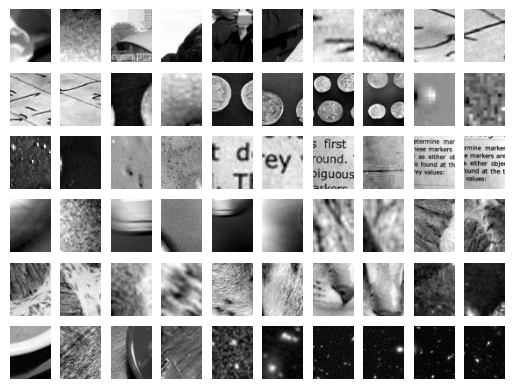

In [14]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

Ελπίζουμε αυτά τα τμήματα εικόνων να καλύπτουν επαρκώς το χώρο των "μη προσώπων" που είναι πιθανό να "δει" ο αλγόριθμός μας.

## 3.Συνδυάστε σύνολα και εξαγάγετε χαρακτηριστικά HOG
Θα συνδυάσουμε τα θετικά δείγματα και αρνητικά δείγματα και θα υπολογίσουμε τα χαρακτηριστικά HOG.

In [15]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [16]:
print(X_train.shape)
print(y_train.shape)

(43233, 1215)
(43233,)


Οπότε έχουμε 43.000 δείγματα εκπαίδευσης με 1.215 χαρακτηριστικά, έτοιμα για εκπαίδευση του δικτύου!

#4. Εκπαίδευση ενός γραμμικού SVM
(Αναλυτικότερα στο μάθημα [Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα
(3319)](https://www.ece.ntua.gr/gr/undergraduate/courses/3319) του 9ο εξαμήνου)

Έχουμε να αντιμετωπίσουμε ένα πρόβλημα δυαδικής ταξινόμησης υψηλής διάστασης. Η επιλογή ενός γραμμικού SVM  είναι μια καλή επιλογή. 
Θα χρησιμοποιήσουμε το Scikit-Learn's LinearSVC, γιατί σε σύγκριση με το SVC έχει συχνά καλύτερη κλίμακα για μεγάλο αριθμό δειγμάτων. 

![](https://drive.google.com/uc?id=1QiM0zTUJ284jHAcq6jrP-WJGNUIwl22T)



Θα χρησιμοποιήσουμε το SVM με αναζήτηση πλέγματος για μερικές επιλογές της παραμέτρου **C** (float, default=1.0) To C είναι παράμετρος κανονικοποίησης. Η ισχύς της κανονικοποίησης είναι αντιστρόφως ανάλογη με το C. Πρέπει να είναι αυστηρά θετικό.)

In [17]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

0.9885272700574659

In [18]:
grid.best_params_

{'C': 2.0}

Ας πάρουμε τον καλύτερο εκτιμητή και να το εκπαιδεύσουμε ξανά στο πλήρες σύνολο δεδομένων:

In [19]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0)

## 5. Βρείτε πρόσωπα σε μια νέα εικόνα 

Θα χρησιμοποιήσουμε ένα τμήμα της εικόνας του αστροναύτη για απλότητα και θα τρέξουμε ένα συρόμενο παράθυρο πάνω του και θα αξιολογήσουμε κάθε patch:

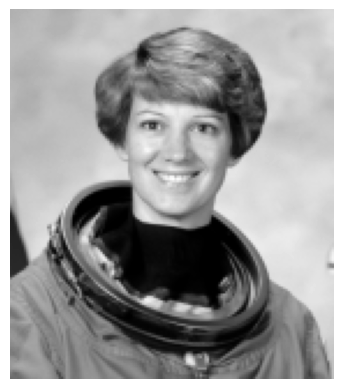

In [20]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Στη συνέχεια, ας δημιουργήσουμε ένα παράθυρο που επαναλαμβάνει τα patches αυτής της εικόνας και ας υπολογίζουμε τα HOG descriptors για κάθε patch:

In [21]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

Τέλος, μπορούμε να πάρουμε αυτά HOG-featured patches και να χρησιμοποιήσουμε το μοντέλο μας για να αξιολογήσουμε εάν κάθε patch περιέχει ένα πρόσωπο:

In [22]:
labels = model.predict(patches_hog)
labels.sum()

46.0

Βλέπουμε ότι από σχεδόν 2.000 patches, έχουμε βρει50 ανιχνεύσεις προσώπου. 

Ας χρησιμοποιήσουμε τις πληροφορίες που έχουμε σχετικά με αυτά τα patches για να δείξουμε πού βρίσκονται στην δοκιμαστική μας εικόνα, σχεδιάζοντας τα ως ορθογώνια:

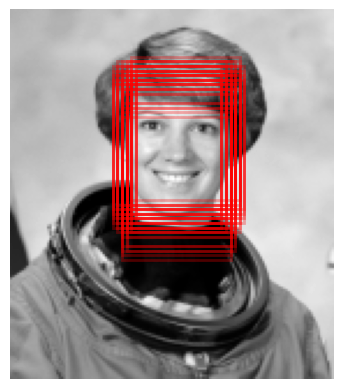

In [23]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

Σε όλα τα ανιχνευμένα και μερικώς επικαλυπτόμενα patches βρέθηκε πρόσωπο!

Τα HOG και άλλες μέθοδοι εξαγωγής χαρακτηριστικών για εικόνες δεν είναι πλέον σύγχρονες τεχνικές.

Αντ 'αυτού, πολλές σύγχρονες τεχνικές αναγνώρισης αντικειμένων χρησιμοποιούν παραλλαγές βαθιών νευρωνικών δικτύων: ένας τρόπος να σκεφτούμε τα νευρωνικά δίκτυα είναι ότι είναι ένας εκτιμητής που καθορίζει τις βέλτιστες στρατηγικές εξαγωγής χαρακτηριστικών από τα δεδομένα, αντί να βασίζεται στη διαίσθηση του χρήστη.